In [14]:
import glob
import pandas as pd
import mne
import matplotlib.pyplot as plt
from io import StringIO
import mne
from mne.io import read_raw_eeglab, read_epochs_eeglab
import numpy as np
from scipy import signal
from scipy import fftpack
import seaborn as sns
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from tqdm import tqdm, tqdm_notebook
import math

from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from keras_tqdm import TQDMNotebookCallback
from tensorboard.plugins.hparams import api as hp
from livelossplot.tf_keras import PlotLossesCallback

import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
import multiprocessing
from tpot import TPOTRegressor
from oct2py import octave

from joblib import Parallel, delayed
import multiprocessing
from joblib import wrap_non_picklable_objects
import json
import pickle
import os.path
from mpl_toolkits.mplot3d import axes3d
import timeit
from skimage.transform import resize
from timeit import default_timer as timer
from datetime import timedelta
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.models import Model, load_model
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.utils import plot_model

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod import bayes_mixed_glm as glm

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV

from spectrum import arburg, arma2psd, pburg
import pylab
from scipy.signal import find_peaks

In [15]:
df_power = pd.read_excel('122-no-hjorth-v3.xlsx')

In [16]:
df_power.head()

,Unnamed: 0,AF3_beta_phase,AF3_beta_power,AF3_gamma_phase,AF3_gamma_power,AF3_high_beta_phase,AF3_high_beta_power,AF3_high_gamma_phase,AF3_high_gamma_power,AF3_low_beta_phase,...,mep_by_cmap,mep_cat_abs,mep_cat_cmap,mep_cat_percentile,mep_duration,mep_latency,mep_size,run,sub,trial_num
0,0,63.122684,4.536592,56.799111,4.633779,31.721667,4.063878,52.763602,4.580448,79.800294,...,0.115366,1,1,1,0.2534,0.0208,2.555237,SP 110RMT r1,sub03,0
1,1,234.489502,5.161802,43.093444,5.563368,229.305916,4.988481,15.706852,5.641140,241.616465,...,0.040370,1,0,0,0.2452,0.0224,0.894165,SP 110RMT r1,sub03,1
2,2,258.081834,5.460213,226.242543,6.081591,258.610050,5.606448,102.926195,6.292829,252.918943,...,0.027123,1,0,0,0.2520,0.0222,0.600739,SP 110RMT r1,sub03,2
3,3,261.465087,5.740030,324.997974,5.531065,264.486221,5.658357,304.889155,5.701548,253.164808,...,0.028755,1,0,0,0.2538,0.0220,0.636902,SP 110RMT r1,sub03,3
4,4,219.977673,6.345027,102.741044,5.561858,224.916069,6.147498,87.951806,5.213091,138.083361,...,0.026999,1,0,0,0.2516,0.0218,0.597992,SP 110RMT r1,sub03,4


# MEP normalization

In [17]:
df_power['subexp'] = df_power['sub'] + '.' + df_power['exp']
df_new_powers = []
for subexp in tqdm(df_power['subexp'].unique()):
    df_sub = df_power[df_power['subexp'] == subexp]
    mep_size = df_sub['mep_size'].values
    mep_size = (mep_size - np.min(mep_size)) / (np.max(mep_size) - np.min(mep_size))
    df_sub['mep_size'] = mep_size
    df_sub['mep_size_log'] = np.log(0.03+mep_size)
    df_sub['mep_by_cmap'] = mep_size / np.mean(df_sub['cmap'].values)
    df_sub['mep_by_cmap_log'] = np.log(0.002+df_sub['mep_by_cmap'].values)
    df_new_powers.append(df_sub)

  0%|          | 0/18 [00:00<?, ?it/s]/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/raquib/anaconda3/envs/tmseeg/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [18]:
new_powers = []
for block in df_new_powers:
    for idx, row in block.iterrows():
        new_powers.append(row)
df_new_powers = pd.DataFrame(new_powers)
df_new_powers.shape

(1876, 982)

In [19]:
df_new_powers.to_excel('123-mep-normalize-v1.xlsx')

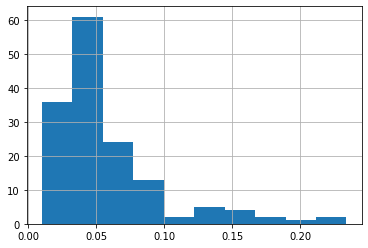

In [41]:
df_power[df_power['subexp'] == 'sub03.exp01']['mep_by_cmap'].hist()

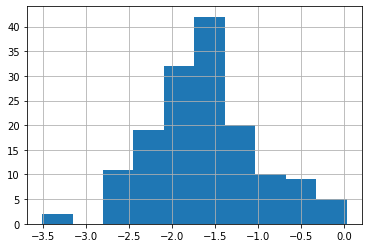

In [51]:
df_new_powers[df_new_powers['subexp'] == 'sub03.exp01']['mep_size_log'].hist()

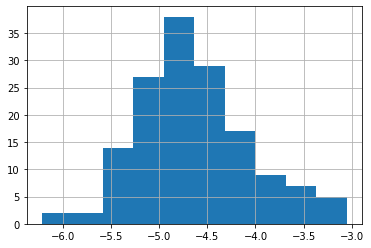

In [50]:
np.log(0.002+df_new_powers[df_new_powers['subexp'] == 'sub03.exp01']['mep_by_cmap']).hist()

# EEG power normalization

In [5]:
# channels = ['C3', 'C4', 'LTM1', 'RTM1', 'RTOCC', 'LTOCC']
# df_power['subexp'] = df_power['sub'] + '.' + df_power['exp']
# df_new_powers = []
# for subexp in tqdm(df_power['subexp'].unique()):
#     df_sub = df_power[df_power['subexp'] == subexp]
#     for column in df_sub.columns.values:
#         for channel in channels:
#             if (channel in column) & ('power' in column):
#                 vals = df_sub[column].values
#                 df_sub[column] = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
#     df_new_powers.append(df_sub)

In [6]:
# len(df_new_powers)

In [7]:
# new_powers = []
# for block in df_new_powers:
#     for idx, row in block.iterrows():
#         new_powers.append(row)
# df_new_powers = pd.DataFrame(new_powers)
# df_new_powers.shape

In [8]:
# df_power.shape

In [9]:
# df_power[df_power['subexp'] == 'sub04.exp01']['C3_mu_power'].hist()

In [10]:
# df_new_powers[df_new_powers['subexp'] == 'sub04.exp01']['C3_mu_power'].hist()

In [11]:
# df_new_powers.to_excel('123-normalized.xlsx')